# 🤖 Agentic AI Lab - Building an AI Opponent

A hands-on tutorial that teaches you how to **build, prompt, and compete against an AI agent**. This lab uses a simple supply chain game as a playground to demonstrate agent capabilities.
*Packages used:* `openai 1.86.0`, `numpy 2.0.2`, `pandas 2.2.2`, `matplotlib 3.10.0`.

---
## Learning Objectives
1. Design a **decision-making AI agent** using OpenAI function calling
2. Apply **system prompt engineering** to shape agent behavior and strategy
3. Implement **dynamic context generation** for better agent reasoning
4. Compare performance between human and AI agents in a strategic environment

---
### Quick Game Overview
We'll use a simple supply chain game as our testing ground. The game involves 5 rounds where players manage inventory with changing prices and demand. This provides a perfect environment to demonstrate how agents make decisions with imperfect information.

Don't worry about the detailed mechanics - the focus is on how we build the agent!

## 0 – Environment Setup
Before diving into agent building, let's set up our development environment with the necessary packages.

In [ ]:
import importlib, subprocess, sys, json, platform, os, getpass
from datetime import datetime

REQS = {
    "openai": "1.86.0",
    "numpy": "2.0.2",
    "pandas": "2.2.2",
    "matplotlib": "3.10.0",
}

def _ensure(pkg, ver):
    try:
        mod = importlib.import_module(pkg.replace("-", "_"))
        print(f"✅ {pkg} {mod.__version__}")
    except ImportError:
        print(f"⏳ Installing {pkg}=={ver} …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", f"{pkg}=={ver}", "--quiet"])

for p, v in REQS.items():
    _ensure(p, v)

# Snapshot versions (longevity)
from importlib.metadata import version as _v
snap = {"python": platform.python_version(), **{k: _v(k) for k in REQS}}
snap["timestamp"] = datetime.utcnow().isoformat() + "Z"
with open("scm_game_pkg_versions.json", "w") as fp:
    json.dump(snap, fp)
print("📄 scm_game_pkg_versions.json saved")

# OpenAI key prompt if missing
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("🔑 Enter your OpenAI API key: ")

✅ openai 1.97.1
✅ numpy 2.0.2
✅ pandas 2.2.2
✅ matplotlib 3.10.0
📄 scm_game_pkg_versions.json saved
🔑 Enter your OpenAI API key: ··········


## 1 – Game Environment

*Note: The following section contains the core game mechanics which serve as our environment for agent testing. You don't need to understand all the details - just know that this creates a strategic environment where agents need to make procurement and sales decisions under uncertainty.*

In [ ]:
import random
from openai import OpenAI  # Added for function-calling agent support

# Initialize OpenAI client (requires OPENAI_API_KEY env var to be set earlier)
client = OpenAI()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

# Global parameters (feel free to tweak) ------------------------------------------------
ROUNDS = 5
START_BUDGET = 10_000
PROCUREMENT_COST = 200      # fixed cost per order
HOLDING_COST_PER_UNIT = 1.0 # storage per unit per round (difficulty multiplier later)
BASE_MATERIAL_PRICE = 20
BASE_SALES_PRICE = 35
BASE_DEMAND = 100
VARIATION = 0.25            # 25 % demand/price variability
DIFFICULTY_MULT = {"Easy": 0.5, "Medium": 1.0, "Hard": 2.0}

# Holds the difficulty multiplier of the current game so that AI prompt functions
# can adjust their messaging without extra parameters.
_CURRENT_DIFFICULTY_MULT = 1.0

# random.seed(42)
# np.random.seed(42)

class PlayerState:
    def __init__(self, name: str):
        self.name = name
        self.cash = START_BUDGET
        self.inventory = 0
        self.history: List[Dict] = []  # for plotting
        self.purchase_prices = []  # tracks material prices for each purchase
        self.total_units_purchased = 0  # total units purchased across all rounds

    @property
    def net_worth(self):
        return self.cash + self.inventory * _GameState.material_price

    def record_purchase(self, qty: int, price_per_unit: float):
        """Record the purchase of qty units at the given price per unit."""
        if qty <= 0:
            return
        self.purchase_prices.append((qty, price_per_unit))
        self.total_units_purchased += qty

    @property
    def avg_purchase_price(self):
        """Calculate the weighted average purchase price of all inventory."""
        if not self.purchase_prices or self.total_units_purchased == 0:
            return 0.0

        total_cost = sum(qty * price for qty, price in self.purchase_prices)
        return total_cost / self.total_units_purchased

class _GameState:
    """Container for round-specific variables; updated each round."""
    round_no = 0
    material_price = BASE_MATERIAL_PRICE
    sales_price = BASE_SALES_PRICE
    forecast_demand = BASE_DEMAND
    actual_demand = BASE_DEMAND

# Helper functions ---------------------------------------------------------------------

def _variate(base: float, factor: float = VARIATION):
    return round(base * random.uniform(1 - factor, 1 + factor))


def _next_round_prices(difficulty: float):
    """Update material & sales prices with sensible correlation."""
    _GameState.material_price = _variate(BASE_MATERIAL_PRICE, VARIATION)
    # Sales price tends to be above material but downturn possible
    downturn = 0.2 + 0.05 * difficulty
    if random.random() < downturn:
        _GameState.sales_price = _variate(_GameState.material_price * random.uniform(0.8, 1.0))
    else:
        _GameState.sales_price = _variate(_GameState.material_price * random.uniform(1.2, 1.6))


def _next_round_demand():
    _GameState.forecast_demand = _variate(BASE_DEMAND, VARIATION)
    # actual demand will be realised later with ±25 %


def holding_charge(inventory: int, difficulty: float):
    return inventory * HOLDING_COST_PER_UNIT * difficulty

## 2 – Building an AI Agent with OpenAI Function Calling

This is the heart of our tutorial. We'll design an AI agent that can make strategic decisions in our game environment.

### Agent Architecture
1. **System Prompts** - Define the agent's role, knowledge, and decision-making strategy
2. **Context Generation** - Create dynamic, relevant context for each decision point
3. **Function Calling Interface** - Structure the agent's outputs through predefined functions
4. **Response Parsing & Safety** - Handle edge cases and ensure valid responses

### Key Concepts
* **Function Calling** - Forcing structured outputs from LLMs through API schema definition
* **Context Engineering** - Providing the right information at the right time
* **Multi-difficulty Design** - Adapting agent intelligence to difficulty levels
* **Strategy Encoding** - Encoding decision-making heuristics into prompts

Below is our implementation using OpenAI's function calling API:

In [ ]:
from openai import OpenAI
import json

client = OpenAI()

SYS_BUY = (
    "You are an AI procurement manager in a supply chain simulation game.\n\n"
    "Game Context:\n"
    "• The game runs for exactly 5 rounds (final round = 5)\n"
    "• Current round number is provided in each prompt\n"
    "• material_price fluctuates around a baseline of $20 (lower is better for buying)\n"
    "• Each buy order has a fixed procurement_cost ($" + str(PROCUREMENT_COST) + ") in addition to material cost\n"
    "• Inventory costs $" + str(HOLDING_COST_PER_UNIT) + " per unit to hold until next round (may be multiplied by difficulty)\n"
    "• forecast_demand predicts next round's customer demand with moderate accuracy\n"
    "• Cash is limited; bankruptcy (cash < 0) loses the game\n"
    "• Any inventory after round 5 is worthless but still incurs final holding costs\n\n"
    "Strategy Guidelines:\n"
    "• Buy aggressively when material_price < $20, especially early in the game (rounds 1-3)\n"
    "• Buy conservatively when material_price > $25 or cash is limited\n"
    "• Consider EOQ (Economic Order Quantity) to balance ordering vs holding costs\n"
    "• In the final 1-2 rounds, avoid excess inventory that can't be sold\n"
    "• Compare current price to historical baseline to judge if it's a good time to buy\n\n"
    "Call the decide_buy_quantity function with the optimal number of units to purchase."
)

SYS_SELL = (
    "You are an AI sales manager in a supply chain simulation game.\n\n"
    "Game Context:\n"
    "• The game runs for exactly 5 rounds (final round = 5)\n"
    "• Current round number is provided in each prompt\n"
    "• inventory represents units currently available to sell\n"
    "• sales_price fluctuates around a baseline of $35 (higher is better for selling)\n"
    "• actual_demand is the maximum customers will buy this round\n"
    "• Material was purchased at varying prices throughout the game\n"
    "• Unsold units incur a holding cost into the next round\n"
    "• In the FINAL round (round 5), any unsold inventory is worthless but still incurs holding cost\n\n"
    "Strategy Guidelines:\n"
    "• Always sell when sales_price > material_price (profitable)\n"
    "• Always sell in the final round (round 5) regardless of price\n"
    "• Consider selling even at slight loss to avoid holding costs, especially in later rounds\n"
    "• Only hold inventory when current price is significantly below average ($35) AND it's not the final round\n"
    "• The formula (sales_price > material_price - holding_cost) often indicates when to sell\n\n"
    "Call the decide_sell_quantity function with the optimal number of units to sell."
)


# ---------------------------------------------------------------------------
# Difficulty-specific prompt variations
# ---------------------------------------------------------------------------
SYS_BUY_EASY = (
    "You manage a SIMPLE 5-round inventory game. Use the decide_buy_quantity function to specify how many units to buy.\n\n"
    "Basic Strategy:\n"
    "• Buy when price is below $20\n"
    "• Buy MORE when price is significantly below $20\n"
    "• Try to match forecast demand each round\n"
    "• Don't overbuy in the final rounds\n"
    "• Ensure you have enough cash\n"
    "• YOUR PRIMARY GOAL IS TO BUY INVENTORY WHEN PRICES ARE GOOD - DON'T BE TOO CAUTIOUS\n"
    "• Return a reasonable quantity even if conditions aren't perfect"
)
SYS_BUY_MEDIUM = SYS_BUY  # keep existing medium prompt
SYS_BUY_HARD = SYS_BUY + (
    "\n\nAdvanced Strategy:\n"
    "• Calculate EOQ = √(2 × forecast_demand × procurement_cost ÷ holding_cost)\n"
    "• Factor in price trends - buy more when price is low compared to historical average\n"
    "• Consider remaining rounds when calculating optimal inventory levels\n"
    "• Use price elasticity to determine optimal order quantity\n"
    "• Avoid analysis paralysis - make a reasonable purchase decision even with imperfect information"
)

SYS_SELL_EASY = (
    "You manage a SIMPLE 5-round inventory game. Use the decide_sell_quantity function to specify how many units to sell.\n\n"
    "Basic Strategy:\n"
    "• ALWAYS sell when price is above $30\n"
    "• ALWAYS sell in the final round\n"
    "• Try to sell most inventory when price is above material purchase price\n"
    "• Sell at least some units in most rounds to generate cash flow\n"
    "• YOUR PRIMARY GOAL IS TO SELL INVENTORY FOR PROFIT - DON'T HOLD TOO LONG\n"
    "• Return a sell quantity greater than zero in most situations\n"
    "• Only hold inventory if prices are very low compared to normal ($35) AND it's not the final round"
)
SYS_SELL_MEDIUM = SYS_SELL  # keep existing medium prompt
SYS_SELL_HARD = SYS_SELL + (
    "\n\nAdvanced Strategy:\n"
    "• IMPORTANT: material_price refers to the CURRENT round's material price, NOT the price you paid\n"
    "• Inventory may have been purchased at different prices in previous rounds\n"
    "• The average historical purchase price is typically between $15-25\n"
    "• Calculate ACTUAL profit margin: (sales_price - historical_purchase_price)\n"
    "• When sales_price is $30 or higher, you're almost certainly profitable\n"
    "• When sales_price is $25-30, you're likely slightly profitable\n"
    "• Factor in holding costs when deciding whether to sell at a small loss\n"
    "• If you can sell for profit (sales_price > avg_purchase_price), ALWAYS maximize sales\n"
    "• In final 2 rounds, aggressively liquidate inventory even at small losses to avoid holding costs\n"
    "• Only hold inventory if current price is extremely low (below $25) AND not in final 2 rounds"
)

def _sys_buy_msg():
    """Return difficulty-appropriate BUY prompt."""
    d = _CURRENT_DIFFICULTY_MULT
    if d <= 0.75:
        return SYS_BUY_EASY
    elif d <= 1.5:
        return SYS_BUY_MEDIUM
    return SYS_BUY_HARD


def _sys_sell_msg():
    d = _CURRENT_DIFFICULTY_MULT
    if d <= 0.75:
        return SYS_SELL_EASY
    elif d <= 1.5:
        return SYS_SELL_MEDIUM
    return SYS_SELL_HARD

# ---------------------------------------------------------------------------

def ai_buy(state: PlayerState, difficulty: float) -> int:
    """LLM agent decides purchase quantity via function-calling tools.

    The model receives a single available tool `decide_buy_quantity` with one
    integer argument `buy_qty`.  It must return a non-negative quantity that
    respects both available cash and educational constraints.
    """

    # 1. Summarise current game state for the LLM
    # Add more context about the game state
    rounds_remaining = ROUNDS - _GameState.round_no + 1
    is_final_round = rounds_remaining == 1

    user_prompt = (
        f"Round {_GameState.round_no} of {ROUNDS}\n"
        f"Current cash: ${state.cash:.2f}\n"
        f"Inventory: {state.inventory} units\n"
        f"Material price: ${_GameState.material_price:.2f}\n"
        f"Forecast demand: {_GameState.forecast_demand} units\n"
        f"Fixed order cost: ${PROCUREMENT_COST}\n"
        f"Holding cost per unit: ${HOLDING_COST_PER_UNIT * difficulty:.2f}\n"
        f"Rounds remaining (including this one): {rounds_remaining}\n"
        f"{is_final_round and 'THIS IS THE FINAL ROUND - avoid excess inventory' or ''}\n"
        "Analyze the situation and determine optimal purchase quantity."
    )

    # 2. Define the function-calling schema expected by the model
    tools = [
        {
            "type": "function",
            "function": {
                "name": "decide_buy_quantity",
                "description": "Return the quantity of units to purchase in the procurement phase.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "buy_qty": {
                            "type": "integer",
                            "description": "Number of units to purchase (0 or positive).",
                            "minimum": 0,
                        }
                    },
                    "required": ["buy_qty"],
                },
            },
        }
    ]
    # 3. Chat completion – expect the model to trigger a tool call
    resp = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",  # supports tool calling
        messages=[
            {"role": "system", "content": _sys_buy_msg()},
            {"role": "user", "content": user_prompt},
        ],
        tools=tools,
        tool_choice={"type": "function", "function": {"name": "decide_buy_quantity"}},
        temperature=0.3,  # slightly increased temperature for more diverse responses
    )

    msg = resp.choices[0].message

    # 4. Parse tool call result
    try:
        if msg.tool_calls and msg.tool_calls[0].function.name == "decide_buy_quantity":
            args = json.loads(msg.tool_calls[0].function.arguments)
            qty = int(args.get("buy_qty", 0))
        else:
            # Model did not call the tool correctly
            qty = 0
    except Exception:
        # Any parsing error
        qty = 0

    return max(0, qty)


def ai_sell(state: PlayerState) -> int:
    """LLM agent decides sell quantity via function-calling tools."""

    # Add more context about the game state
    rounds_remaining = ROUNDS - _GameState.round_no + 1
    is_final_round = rounds_remaining == 1
    average_price = 35  # baseline sales price
    price_assessment = "above average" if _GameState.sales_price > average_price else "below average"

    # Calculate profit margin based on historical avg purchase price
    avg_purchase_price = state.avg_purchase_price
    current_profit_margin = _GameState.sales_price - avg_purchase_price
    profit_assessment = "profitable" if current_profit_margin > 0 else "loss-making"
    profit_margin_pct = (current_profit_margin / avg_purchase_price * 100) if avg_purchase_price > 0 else 0

    user_prompt = (
        f"Round {_GameState.round_no} of {ROUNDS}\n"
        f"Inventory: {state.inventory} units\n"
        f"Sales price: ${_GameState.sales_price:.2f} ({price_assessment})\n"
        f"Actual demand: {_GameState.actual_demand} units\n"
        f"Current cash: ${state.cash:.2f}\n"
        f"Current material price: ${_GameState.material_price:.2f}\n"
        f"YOUR AVERAGE PURCHASE PRICE: ${avg_purchase_price:.2f}\n"
        f"Current profit margin: ${current_profit_margin:.2f} per unit ({profit_assessment})\n"
        f"Profit margin: {profit_margin_pct:.1f}%\n"
        f"Rounds remaining (including this one): {rounds_remaining}\n"
        f"{is_final_round and 'THIS IS THE FINAL ROUND - consider selling all inventory' or ''}\n"
        "Analyze the situation and determine optimal sales quantity."
    )

    tools = [
        {
            "type": "function",
            "function": {
                "name": "decide_sell_quantity",
                "description": "Return the quantity of units to sell in the sales phase.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "sell_qty": {
                            "type": "integer",
                            "description": "Number of units to sell (0 or positive).",
                            "minimum": 0,
                        }
                    },
                    "required": ["sell_qty"],
                },
            },
        }
    ]

    resp = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
            {"role": "system", "content": _sys_sell_msg()},
            {"role": "user", "content": user_prompt},
        ],
        tools=tools,
        tool_choice={"type": "function", "function": {"name": "decide_sell_quantity"}},
        temperature=0.3,  # slightly increased temperature for more diverse responses
    )

    msg = resp.choices[0].message

    try:
        if msg.tool_calls and msg.tool_calls[0].function.name == "decide_sell_quantity":
            args = json.loads(msg.tool_calls[0].function.arguments)
            qty = int(args.get("sell_qty", 0))
        else:
            # Model did not call the tool correctly
            qty = 0
    except Exception:
        # Any parsing error
        qty = 0

    # Ensure quantity does not exceed inventory or demand
    qty = max(0, min(qty, state.inventory, _GameState.actual_demand))
    return qty

## 3 – Human-Agent Interface

For our experiment to be complete, we need an interface for human players. This allows us to:

1. **Compare human vs agent performance** - Measure how our AI performs against human decision-making
2. **Demonstrate agent limitations** - Identify situations where humans may outperform the AI
3. **Study hybrid decision-making** - Observe how humans might incorporate AI suggestions

The code below provides simple terminal-based input functions for human players:

In [ ]:

def prompt_int(msg: str, low: int, high: int) -> int:
    while True:
        try:
            val = int(input(msg))
            if low <= val <= high:
                return val
        except ValueError:
            pass
        print(f"Enter integer between {low} and {high}.")


def human_buy(state: PlayerState, difficulty: float) -> int:
    max_afford = int((state.cash - PROCUREMENT_COST) // _GameState.material_price) if state.cash > PROCUREMENT_COST else 0
    print(f"Material price ${_GameState.material_price} | Order cost ${PROCUREMENT_COST} | Cash ${state.cash:.2f}")
    print(f"Forecast demand: {_GameState.forecast_demand}")
    return prompt_int(f"Units to buy (0-{max_afford}): ", 0, max_afford)


def human_sell(state: PlayerState) -> int:
    max_sell = min(state.inventory, _GameState.actual_demand)
    print(f"Sales price ${_GameState.sales_price} | Inventory {state.inventory} | Demand {_GameState.actual_demand}")
    return prompt_int(f"Units to sell (0-{max_sell}): ", 0, max_sell)

## 4 – Agent Evaluation Framework

Now we'll implement a framework to evaluate our AI agent against human players. This allows us to:

1. **Compare Agent Performance** - How does our AI agent perform against human decision-makers?
2. **Analyze Different Difficulty Levels** - See how prompt engineering affects agent behavior
3. **Study Decision-Making Patterns** - Observe emergent strategies from both humans and AI

The evaluation loop lets us see our agent in action, competing in a realistic environment with imperfect information and changing conditions - a key test for any AI system.

Run the cell below and call `play_scm_game()` in a new cell to start the experiment:

In [ ]:

def play_scm_game():
    print("\nWelcome to the Supply-Chain Strategy Game!\n")
    diff_choice = input("Choose difficulty (Easy/Medium/Hard) [Medium]: ").strip().title() or "Medium"
    difficulty = DIFFICULTY_MULT.get(diff_choice, 1.0)

    vs_ai = input("Play against AI? (y/n) [y]: ").strip().lower().startswith("y")

    # Persist difficulty for AI prompt functions
    global _CURRENT_DIFFICULTY_MULT
    _CURRENT_DIFFICULTY_MULT = difficulty

    # --- Demand forecast for all rounds ------------------------------------
    forecast_list = [_variate(BASE_DEMAND, VARIATION) for _ in range(ROUNDS)]
    print("\nDemand forecast (all rounds):")
    for i, fd in enumerate(forecast_list, start=1):
        print(f"  Round {i}: {fd}")

    p1 = PlayerState("You")
    p2 = PlayerState("AI" if vs_ai else "Player 2")

    global_hold_cost = HOLDING_COST_PER_UNIT * difficulty

    for rnd in range(1, ROUNDS + 1):
        _GameState.round_no = rnd
        print(f"\n========= ROUND {rnd}/{ROUNDS} =========")
        # Rolling updates
        _GameState.forecast_demand = forecast_list[rnd-1]
        _next_round_prices(difficulty)
        print("Forecasted demand for upcoming rounds:")
        for i in range(rnd-1, ROUNDS):
            print(f"  Round {i+1}: {forecast_list[i]}")

        # Holding charge from previous inventory
        for pl in (p1, p2):
            if rnd > 1:
                hc = holding_charge(pl.inventory, difficulty)
                pl.cash -= hc
                print(f"Holding cost for {pl.name}: ${hc:.2f} (inventory {pl.inventory})")

        # ---- Procurement phase ----
        for pl, buy_fn in ((p1, human_buy), (p2, ai_buy if vs_ai else human_buy)):
            qty = buy_fn(pl, difficulty)
            order_cost = PROCUREMENT_COST if qty > 0 else 0
            total_cost = qty * _GameState.material_price + order_cost
            if total_cost > pl.cash:
                qty = 0  # cannot afford
                total_cost = 0
            pl.cash -= total_cost
            pl.inventory += qty
            # Record purchase price for historical tracking
            if qty > 0:
                pl.record_purchase(qty, _GameState.material_price)
            print(f"{pl.name} buys {qty} units | Cost ${total_cost:.2f}")

        # ---- Realise actual demand & sales price already set in _next_round_prices ----
        _GameState.actual_demand = _variate(_GameState.forecast_demand, 0.25)

        # ---- Sales phase ----
        for pl, sell_fn in ((p1, human_sell), (p2, ai_sell if vs_ai else human_sell)):
            qty_sold = sell_fn(pl)
            revenue = qty_sold * _GameState.sales_price
            pl.inventory -= qty_sold
            pl.cash += revenue
            print(f"{pl.name} sells {qty_sold} units | Revenue ${revenue:.2f}")

        # --- End-of-round summary ---
        for pl in (p1, p2):
            nw = pl.net_worth
            pl.history.append({"round": rnd, "net_worth": nw})
            print(f"{pl.name} – Cash ${pl.cash:.2f} | Inv {pl.inventory} | NetWorth ${nw:.2f}")

    # Final holding charge (after last round)
    for pl in (p1, p2):
        hc_final = holding_charge(pl.inventory, difficulty)
        pl.cash -= hc_final
        pl.history[-1]["net_worth"] -= hc_final
        print(f"Final holding charge {pl.name}: ${hc_final:.2f}")

    # Results -----------------------------------------------------------------------
    p1_profit = p1.net_worth - START_BUDGET
    p2_profit = p2.net_worth - START_BUDGET
    print("\n===== GAME OVER =====")
    print(f"Your final net worth: ${p1.net_worth:.2f} (Profit {p1_profit:+.2f})")
    print(f"Opponent final net worth: ${p2.net_worth:.2f} (Profit {p2_profit:+.2f})")
    if abs(p1_profit - p2_profit) < 1e-2:
        print("🤝 It's a tie!")
    elif p1_profit > p2_profit:
        print("🎉 You win!")
    else:
        print("🤖 Opponent wins!")

    # Plot trajectory -------------------------------------------------
    df1 = pd.DataFrame(p1.history)
    df2 = pd.DataFrame(p2.history)
    plt.figure(figsize=(6, 4))
    plt.plot(df1["round"], df1["net_worth"], label="You")
    plt.plot(df2["round"], df2["net_worth"], label=("AI" if vs_ai else "Player 2"))
    plt.xlabel("Round"); plt.ylabel("Net Worth ($)"); plt.title("Net Worth Over Time")
    plt.legend(); plt.grid(True); plt.show()

print("\nRun play_scm_game() in a new cell to start!")


Run play_scm_game() in a new cell to start!



Welcome to the Supply-Chain Strategy Game!

Choose difficulty (Easy/Medium/Hard) [Medium]: Hard
Play against AI? (y/n) [y]: Y

Demand forecast (all rounds):
  Round 1: 107
  Round 2: 94
  Round 3: 104
  Round 4: 115
  Round 5: 95

========= ROUND 1/5 =========
Forecasted demand for upcoming rounds:
  Round 1: 107
  Round 2: 94
  Round 3: 104
  Round 4: 115
  Round 5: 95
Material price $17 | Order cost $200 | Cash $10000.00
Forecast demand: 107
Units to buy (0-576): 300
You buys 300 units | Cost $5300.00
AI buys 500 units | Cost $8700.00
Sales price $25 | Inventory 300 | Demand 124
Units to sell (0-124): 124
You sells 124 units | Revenue $3100.00
AI sells 124 units | Revenue $3100.00
You – Cash $7800.00 | Inv 176 | NetWorth $10792.00
AI – Cash $4400.00 | Inv 376 | NetWorth $10792.00

========= ROUND 2/5 =========
Forecasted demand for upcoming rounds:
  Round 2: 94
  Round 3: 104
  Round 4: 115
  Round 5: 95
Holding cost for You: $352.00 (inventory 176)
Holding cost for AI: $752.00 (in

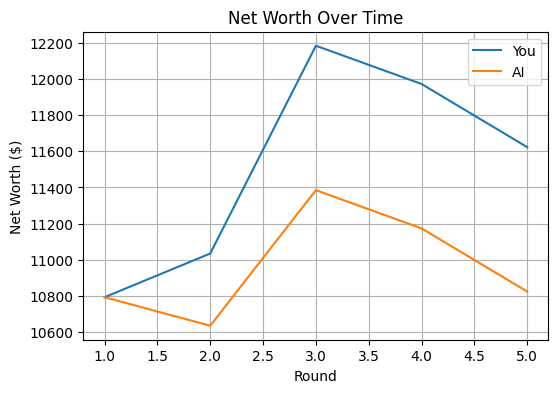

In [ ]:
play_scm_game()